In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import dump

In [2]:
from pathlib import Path
my_csv = Path("/home/cefika/Desktop/ip1/marketing_campaign.csv")
data = pd.read_csv(my_csv.resolve(), sep='\t')

In [3]:
inc_med = data['Income'].median()
data['Income'].fillna(inc_med, inplace=True)

data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

data['NumTotalPurchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'] + data['NumDealsPurchases']
data['Totalacp'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5'] + data['Response']
data['Totalacp']=np.where(data.Totalacp>0,1,0)
#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

to_drop = ['Response','Complain',"Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", 
           "Kidhome", "Teenhome",'AcceptedCmp1',
           'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumDealsPurchases']
data = data.drop(to_drop, axis=1)
data.reset_index(drop=True,inplace=True)

In [4]:
cols = ["Income","Age"]

for i in cols:
    q1 = data[i].quantile(0.25)
    q3 = data[i].quantile(0.75)
    iqr = q3-q1
    
    outliers = data[(data[i]<(q1-1.5*iqr)) | (data[i]>(q3+1.5*iqr))]
    
    #remove the outliers
    data = data[~((data[i]<(q1-1.5*iqr)) | (data[i]>(q3+1.5*iqr)))]
print("Remaining rows :",len(data))
data.reset_index(drop=True,inplace=True)

Remaining rows : 2229


In [5]:
le = LabelEncoder()
data["Education"] = le.fit_transform(data["Education"])
data["Living_With"] = le.fit_transform(data['Living_With'])
data.dtypes

Education              int64
Income               float64
Recency                int64
Wines                  int64
Fruits                 int64
Meat                   int64
Fish                   int64
Sweets                 int64
Gold                   int64
NumWebVisitsMonth      int64
Age                    int64
Spent                  int64
Living_With            int64
Children               int64
Family_Size            int64
Is_Parent              int64
NumTotalPurchases      int64
Totalacp               int64
Customer_For           int64
dtype: object

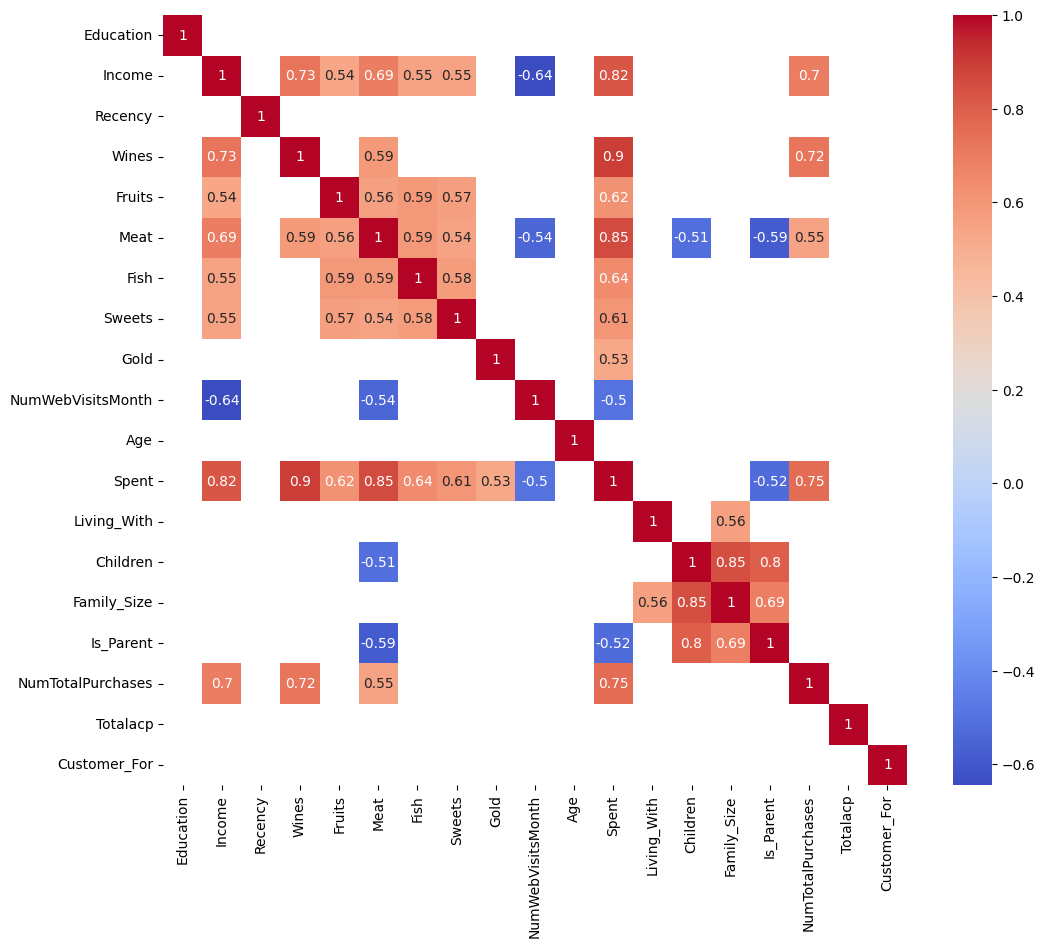

In [6]:
matrica_korelacije = data.corr()

prag = 0.5

korelisani = matrica_korelacije.abs() > prag
korelisani_matrica = matrica_korelacije[korelisani]

plt.figure(figsize=(12, 10))

sns.heatmap(korelisani_matrica, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

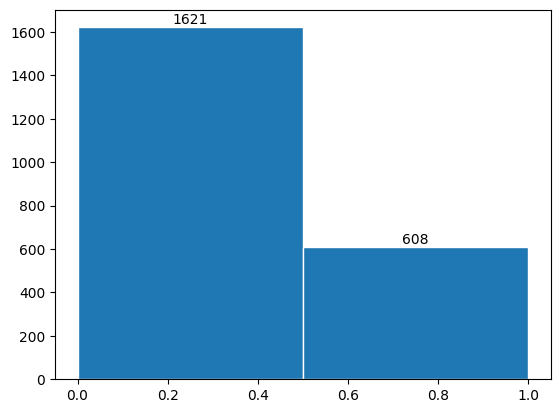

In [7]:
from sklearn.feature_selection import SelectKBest, chi2
X=data.drop(['Totalacp'], axis=1)
y=data['Totalacp']
freq, bins, _ = plt.hist(y, edgecolor='white', bins=2)

bin_centers = np.diff(bins)*0.5 + bins[:-1] # računanje centra korpice

for fr, x in zip(freq, bin_centers):
    height = int(fr)
    plt.annotate("{}".format(height),
               xy = (x, height),             # poziciranje broja iznad korpice
               xytext = (0,0.2),             # odvajanje teksta od korpice
               textcoords = "offset points", 
               ha = 'center', va = 'bottom'
               )

plt.show

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

In [10]:
X_train.describe()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent,NumTotalPurchases,Customer_For
count,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000,1783.000000
mean,0.306786,0.476763,0.495476,0.204266,0.133306,0.095844,0.144169,0.103800,0.120814,0.266826,0.489543,0.238164,0.648345,0.318938,0.401290,0.716209,0.345316,0.480327
std,0.344663,0.201165,0.293064,0.226556,0.202557,0.127223,0.211601,0.158063,0.142492,0.120988,0.210119,0.239335,0.477621,0.253382,0.228143,0.450963,0.178374,0.218761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.318732,0.242424,0.015405,0.005076,0.008986,0.011583,0.003802,0.024862,0.150000,0.345455,0.025010,0.000000,0.000000,0.250000,0.000000,0.162791,0.318438
50%,0.000000,0.474982,0.494949,0.119893,0.040609,0.038261,0.046332,0.030418,0.066298,0.300000,0.472727,0.154029,1.000000,0.333333,0.500000,1.000000,0.348837,0.482596
75%,0.500000,0.637429,0.747475,0.337910,0.162437,0.134783,0.189189,0.129278,0.151934,0.350000,0.654545,0.411274,1.000000,0.333333,0.500000,1.000000,0.488372,0.645343
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
dump((X_train, X_test, y_train, y_test), 'classification_data.joblib')

['classification_data.joblib']